In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

torch.manual_seed(2)

# prepare data

In [12]:
import pickle
import pandas as pd

with open('raw_data.pkl', 'rb') as fp:
    raw_data = pickle.load(fp)

print(raw_data.columns)


Index(['LAT', 'LON', 'YEAR', 'MONTH', 'DAY', 'T2M_RANGE', 'T2M', 'RH2M', 'PS',
       'WS50M', 'WS10M', 'WS50M_RANGE', 'WS10M_RANGE', 'ALLSKY_SFC_SW_DWN',
       'DAY_OF_YEAR', 'SEASONAL', 'T2M_diff'],
      dtype='object')


In [13]:
features = ['T2M_RANGE', 'T2M', 'RH2M', 'PS', 'WS50M', 'WS10M',
                  'WS50M_RANGE', 'WS10M_RANGE', 'ALLSKY_SFC_SW_DWN', 'DAY_OF_YEAR', 'SEASONAL', 'T2M_diff']
target = ['T2M_future_1', 'T2M_future_2', 'T2M_future_3']

def add_nth_day_feature(df, feature, N): #for T2M in future days
    rows = df.shape[0]
    nth_prior_measurements = [df[feature][i+N] for i in range(0, rows-N)] + [None]*N
    col_name = "{}_future_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

#add T2M 2 days in future
for N in range(1, 4):
    add_nth_day_feature(raw_data, 'T2M', N)

#drop NA
raw_data = raw_data.dropna()

print(raw_data.shape)

X = pd.DataFrame()
Y = pd.DataFrame()
for feature in raw_data.columns:
    if feature in features:  # get useful data
        X[feature] = raw_data[feature]

for feature in target:
    Y[feature] = raw_data[feature]

from sklearn.model_selection import train_test_split
leng = int(X.shape[0] * 0.8)

X_train, X_test = X[:leng].values, X[leng:].values
Y_train, Y_test = Y[:leng].values, Y[leng:].values
# X_train, X_test = X[:913].values, X[913:].values
# Y_train, Y_test = Y[:913].values, Y[913:].values

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)
#
# X_train = torch.tensor(X_train.values.astype(np.float32))
# X_test = torch.tensor(X_test.values.astype(np.float32))
# Y_train = torch.tensor(Y_train.values.astype(np.float32))
# Y_test = torch.tensor(Y_test.values.astype(np.float32))

print(X_train)


(1823, 20)
(1458, 12) (365, 12)
(1458, 3) (365, 3)
[[ 4.27000000e+00 -1.60000000e-01  9.00600000e+01 ...  2.00000000e+00
  -1.26130522e+01  1.59000000e+00]
 [ 2.99000000e+00  1.21000000e+00  8.61100000e+01 ...  3.00000000e+00
  -1.36998399e+01  1.37000000e+00]
 [ 2.93000000e+00 -7.00000000e-02  8.57400000e+01 ...  4.00000000e+00
  -1.33798810e+01 -1.28000000e+00]
 ...
 [ 2.25000000e+00  1.51000000e+00  9.75000000e+01 ...  3.61000000e+02
  -6.98674398e+00  5.30000000e-01]
 [ 1.90000000e+00  2.47000000e+00  9.69400000e+01 ...  3.62000000e+02
  -8.58981932e+00  9.60000000e-01]
 [ 3.29000000e+00  9.60000000e-01  9.73100000e+01 ...  3.63000000e+02
  -1.06534152e+01 -1.51000000e+00]]


In [14]:
def get_batches(X, Y, n_seqs, n_steps):
    '''Create a generator that returns batches of size'''
    batch_size = n_seqs * n_steps
    n_batches = len(X)//batch_size #how many this batches will fit

    # Keep only enough characters to make full batches

    X = X[:n_batches * batch_size]
    Y = Y[:n_batches * batch_size]


    # Reshape into n_seqs rows
    # arr = arr.reshape((n_seqs, -1))

    for n in range(0, n_batches):
        iterator = 0
        x = []
        y = []
        for i in range(n_seqs):
            temp_x = []
            temp_y = []
            for j in range(n_steps):
                temp_x.append(X[i*n_steps + j])
                temp_y.append(Y[i*n_steps + j])
            x.append(temp_x)
            y.append(temp_y)

        yield x, y

In [15]:
# gen = get_batches(X_train,Y_train,2,2)
# x, y = next(gen)
# x, y = np.asarray(x), np.asarray(y)
# print(x.shape)

# make models and functions

In [16]:
class myLSTM(nn.Module):

    # Constructor
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_p=0.05):
        super(myLSTM, self).__init__()
        self.n_layers = num_layers
        self.n_hidden = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, dropout = dropout_p)
        self.dropout = nn.Dropout(dropout_p)
        self.final = nn.Linear(hidden_size, output_size)
        self.init_weights()
        self.cuda()

    # Prediction function
    def forward(self, x, hc):
        x, (h, c) = self.lstm(x, hc)
        x = self.dropout(x)
        x = self.final(x)
        return x, (h, c)

    def init_weights(self):
        self.final.bias.data.fill_(0) # set bias to 0
        self.final.weight.data.uniform_(-1,1)

    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        a = weight.new(self.n_layers, n_seqs, self.n_hidden).zero_().double()
        a = a.type(torch.DoubleTensor)
        a = a.cuda()
        b = weight.new(self.n_layers, n_seqs, self.n_hidden).zero_().double()
        b = b.type(torch.DoubleTensor)
        b = b.cuda()
        return (a,b)

In [17]:
def train(model, criterion, verification, X_train, Y_train, X_test, Y_test, optimizer, epochs=100, clip = 5, n_seq = 10, n_steps = 10):
    i = 0
    loss_accuracy = {'training_loss': [], 'validation_error': []}
    model = model.double()
    model.cuda()
    # n_epochs
    for epoch in range(epochs):
        h = model.init_hidden(n_seq)

        model.train()
        for x,y in get_batches(X_train, Y_train, n_seq, n_steps):

            x, y = np.asarray(x), np.asarray(y)
            x, y = torch.from_numpy(x), torch.from_numpy(y)
            x, y = x.cuda(), y.cuda()

            h = tuple([each.data for each in h])

            optimizer.zero_grad()
            z, h = model(x, h)
            loss = criterion(z, y)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

            train_error = verification(z, y)
            loss_accuracy['training_loss'].append(train_error)

        # eval
        model.eval()
        h = model.init_hidden(n_seq)
        for x,y in get_batches(X_test, Y_test, n_seq, n_steps):

            x, y = np.asarray(x), np.asarray(y)
            x, y = torch.from_numpy(x), torch.from_numpy(y)
            x, y = x.cuda(), y.cuda()

            h = tuple([each.data for each in h])

            yhat, h = model(x, h)
            val_error = verification(yhat, y)
            loss_accuracy['validation_error'].append(val_error)


    # print(yhat)
    # print(Y_test)
    return loss_accuracy


In [18]:
lstm_model = myLSTM(len(features), len(features)*3, len(target), num_layers = 2, dropout_p = 0.2)

learning_rate = 0.001
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = learning_rate)
criterion = torch.nn.MSELoss()
verification = torch.nn.L1Loss()\

results = train(lstm_model, criterion, verification, X_train, Y_train, X_test, Y_test, optimizer, epochs=400, n_seq = 10, n_steps = 10)

[]

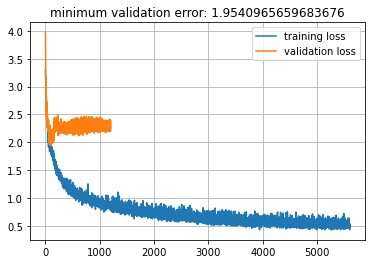

In [19]:
plt.plot(results['training_loss'], label='training loss')
plt.plot(results['validation_error'], label='validation loss')
plt.title(f"minimum validation error: {min(results['validation_error'])}")
plt.grid()
plt.legend()
# plt.draw()
# plt.show(block=True)
plt.plot()

In [21]:
checkpoint = {'n_hidden': lstm_model.n_hidden,
              'n_layers': lstm_model.n_layers,
              'state_dict': lstm_model.state_dict(),
              'model': lstm_model,
            }

torch.save(checkpoint, f'nn_models/LSTM.pt')

# conclusion

As it it seen, the validation result is also around ~2.0*C, not much more information can be squeezed
out of dataset.

The training error is reaching value 0.5, which is 4 time smaller then in simple NN. In this case it
is overfitting our dataset, but also indicates that LSTM draws relationships between features much better
which can be really powerful with bigger dataset and much more features.

